https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/pdf/nihms-802148.pdf

Model early epidemic progression with generalized growth model, which models early sub-exponential growth pattern in infectious disease. It has prooved to fit Ebola and HIV outbreaks in early phases and is considered to work well as a phenomenological, i.e. not mechanistic, model.

**Generalized growth model.**

\begin{align*}
\frac{dC}{dt} = rC^p
\end{align*}

\begin{align*}
p = 1-\frac{1}{m}
\end{align*}

This leads to a sub-exponential, **polynomial growth**:

\begin{align*}
C(t) = (\frac{r}{m} t + A)^m
\end{align*}

This is in contrast to the common, intuitive **exponential model of growth**:

\begin{align*}
E(t) = Ae^{rt}
\end{align*}

In [128]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.fftpack import fft
import matplotlib.pyplot as plt

print(plt.style.available)

['dark_background', 'classic', '_classic_test', 'fivethirtyeight', 'grayscale', 'seaborn-ticks', 'tableau-colorblind10', 'seaborn-pastel', 'seaborn-notebook', 'seaborn', 'seaborn-darkgrid', 'ggplot', 'Solarize_Light2', 'fast', 'seaborn-bright', 'seaborn-dark-palette', 'seaborn-white', 'seaborn-dark', 'seaborn-whitegrid', 'seaborn-deep', 'seaborn-colorblind', 'seaborn-paper', 'seaborn-poster', 'seaborn-muted', 'seaborn-talk', 'bmh']


In [149]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def preprocess(x, n=10):
    padded = np.pad(data, n)
    padded[-n:] = x[-1]
    y = moving_average(padded, n=n*2)
    return y


def plot_preprocessing(x, n=10):
    
    proc = preprocess(data, n)

    plt.plot(data, 'b')
    plt.plot(proc, 'r')
    plt.show()

    ft1 = fft(data)
    ft2 = fft(proc)

    plt.plot(np.absolute(ft1), 'b')
    plt.plot(np.absolute(ft2), 'r')
    plt.show()

    
def C(t: np.array = np.array(range(10)), r=2, m=1, A=0):
    '''Function to be optimized. The generalized growth model.'''
    return (r/m*t+A)**m


def E(t: np.array = np.array(range(10)), A=0, r=2):
    '''Define exponential model to be fit.'''
    return A*np.exp(r*t)


def optimize(data: np.array, model = C):
    '''Optimizes a model for data. Assumes per day data.'''
    x = np.array(range(len(data)))
    y = data.copy()
    popt, pcov = curve_fit(model, x, y,
                          bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
                          method='trf')
    return popt


def predict(ts: np.array, popt: list, model = C):
    '''Predicts total cases at times x.'''
    return model(ts, *popt)


def plot(data, predicted, title=None):
    '''Plot.'''
    
    plt.style.use('seaborn-talk')
    plt.rcParams.update({'axes.titlesize': 28})
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(data, 'oc-', label='data')
    ax.plot(predicted, 'vm-', label='predicted')
    ax.legend(fontsize=20, loc='upper left')
    
    if title:
        ax.set_title(title)
        
    plt.text(x=0.02, y=0.7, transform=ax.transAxes, 
             bbox=dict(facecolor='magenta', alpha=0.5), fontsize=28,
             s=r'$C(t)=(\frac{r}{m}t + A)^m$')
    
    return ax

In [170]:
def workflow_1(data: np.array, seen: int, with_preprocess=False, n=5):
    "Whole workflow for generating plot."
    
    ts = np.array(range(len(data)))

    # Optimize the curve based on first 'seen' days
    print("Cases at day {} = {}".format(seen, data[seen]))
    if with_preprocess:
        proc = preprocess(data[:seen], n)
        popt = optimize(proc)
    else:
        popt = optimize(data[:seen])
    pred = predict(ts, popt)

    ax = plot(data, pred, title='Italy total number of cases prediction, from 15 Feb, based on {} day progression.'.format(seen))
    return ax, pred


def workflow_2(data: np.array, seen: list, model=C, with_preprocess=False, n=5):
    '''Whole workflow for multiple train size.'''
    
    ts = np.array(range(len(data)))
    
    plt.style.use('seaborn-talk')
#     plt.rcParams.update({'axes.titlesize': 28})
    
    markers = ['v', '^', 's']
    colors = ['m', 'r', 'g']
    line = '-'
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    for i, s in enumerate(seen):
        # Optimize the curve based on first 'seen' days
        print("Cases at day {} = {}".format(seen, data[s]))
        if with_preprocess:
            proc = preprocess(data[:s], n)
            popt = optimize(proc, model)
        else:
            popt = optimize(data[:s], model)
        pred = predict(ts, popt, model)
        ax.plot(pred, '{}{}{}'.format(markers[i], colors[i], line), label='Train size = {}, #cases={}'.format(s, data[s]))
    
    ax.plot(data, 'oc-', label='data', linewidth=10)

    
    ax.legend(loc='upper left', fontsize=20)
    ax.set_title("Predicting total cases in Italy using different training sizes.", 
                 fontsize=28)
    
    ax.text(x=0.02, y=0.5, transform=ax.transAxes, 
             bbox=dict(facecolor='magenta', alpha=0.5), fontsize=28,
             s=r'$C(t)=(\frac{r}{m}t + A)^m$')
    plt.savefig("TotalCasePrediction.png")
    
    return ax

In [171]:
# Take Italy case data, worldometrics, from 15 Feb to 15 Mar
data = np.array([
    3,3,3,3,3,4,21,79,157,229,323,470,655,889,
    1128,1701,2036,2502,3089,3858,4636,5883,7375,9172,10149,
    12462,15113,17660,21157,24747,
    # After 15 Mar
    27980,31506,35713,41035,47021,53578
])

# Take Romania data: 15 Feb - 22 March
data_ro = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    1, 1, 3, 3, 3, 3, 3, 4, 6, 9, 9,
    15, 15, 25, 45, 49, 89, 123, 131,
    158, 184, 260, 277, 308, 368, 434
])

# Take Moldova data: 15 Feb - 22 March
data_md = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
    3, 3, 3, 6, 12, 23, 23, 30, 30, 49,
    56, 70, 84
])

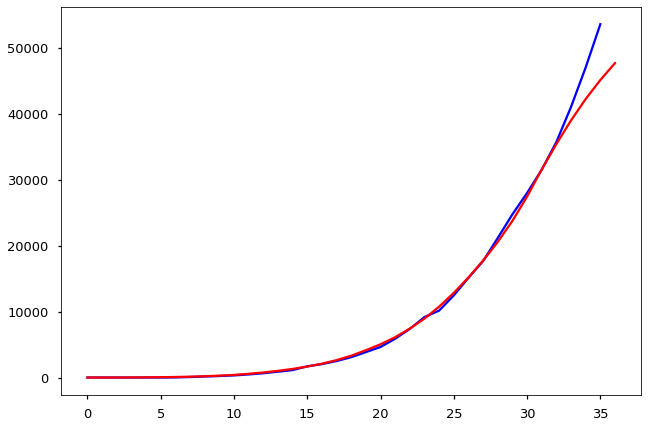

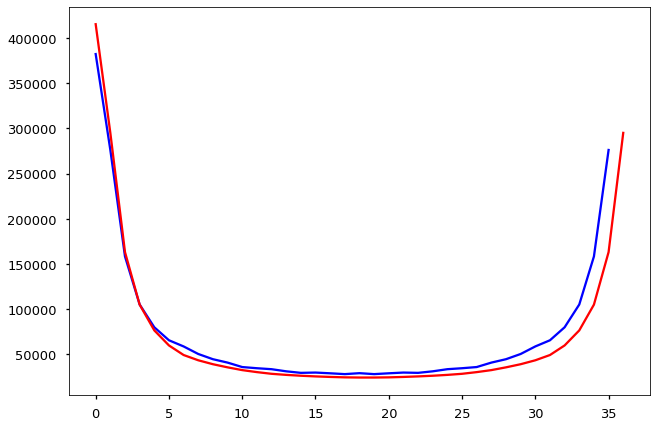

In [197]:
plot_preprocessing(data, 5)

Cases at day [10, 15, 30] = 323
Cases at day [10, 15, 30] = 1701
Cases at day [10, 15, 30] = 27980


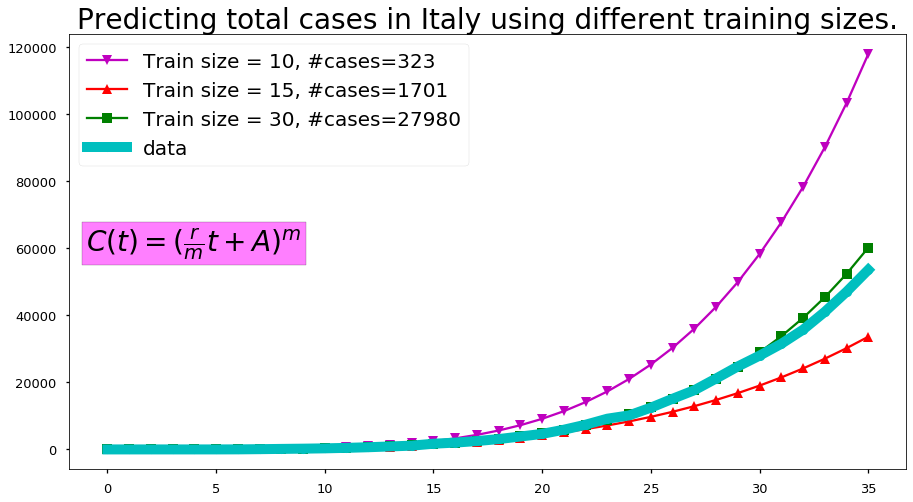

In [196]:
# ax, pred = workflow_1(data_ro, 10, with_preprocess=False, n=1)
ax = workflow_2(data, [10,15,30], model=C)

Cases at day [10, 15, 30] = 323
Cases at day [10, 15, 30] = 1701
Cases at day [10, 15, 30] = 27980


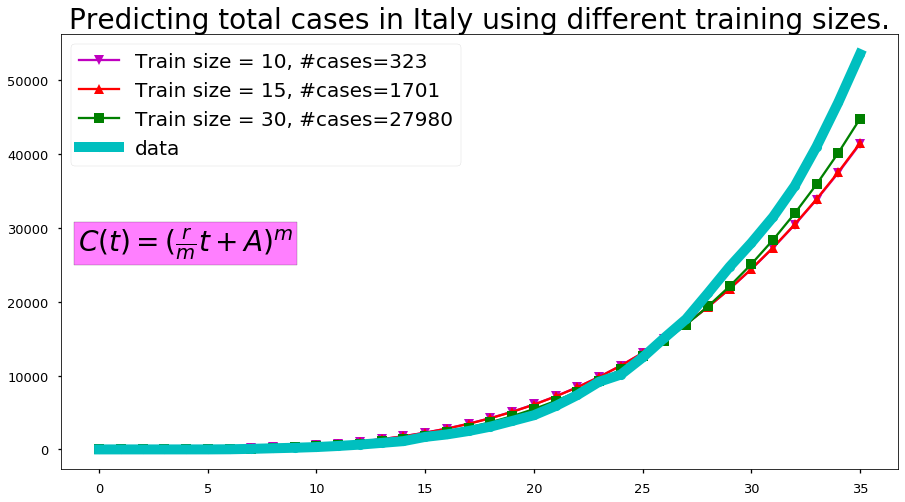

In [191]:
ax = workflow_2(data, [10,15,30], with_preprocess=True, n=1)